# Titanic - Machine Learning from Disaster Project Overview

### 1. Problem Definition
This is a playground Kaggle Competition: https://www.kaggle.com/c/titanic
* While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.
* Given some features of someone, predict whether he will survive from Titanic shipwreck or not. 

### 2. Data 
Data is also available from Kaggle: https://www.kaggle.com/c/titanic/data

**Overview**

The data has been split into two groups:
* training set (train.csv)
* test set (test.csv)

Here are main variables.
1. survival: 1 is Yes, 0 is No.
  * this is **Label** We want to predict.
2. Age: age in years
  * It maybe relates to survival, say eldery is more difficult to survive that youngesters.
3. pclass: A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower


### 3. Evaluation
Evaluation metrics is `accuracy`. https://www.kaggle.com/c/titanic/overview/evaluation

I would like to build a model with:
* 90% accuracy
Also, I should monitor precision, recall, and f1.

Even if the accuracy is great, I reject the model if another metrics were terrible.

### 4. Features
Just guessing, with seeing no nodata, Age itself affects survival.
Also, sex and cabin seem to have impact.

#### **Data manipulation**
- 1. drop Cabin
- 2. drop PassengerId
- 3. drop Name
- 4. Turn Sex into "is_female" and drop Sex
- 5. <font color=red>Age imputation</font>
  - 5-1. midium of each Parch
   - 5-1-1. age binning (Age_class)
  - 5-2. midium of each SibSp
  - 5-3. (average, max, min) of 5-1 and 5-2
  - 5-4. sqet of 5-1 and 5-2
- 6. drop Ticket 
- 7. Fare binning
- 8. Embark --> "S", "not S", and "missing"

### 5. Model
- Cross Validation

The problem is binary classification.
<img src="https://drive.google.com/uc?id=1FGvA69pXd97vrEeumbVIvRccvUrYYrPF" width="600">
 https://www.analyticsvidhya.com/blog/2020/11/popular-classification-models-for-machine-learning/

I will choose model after analyzing features.


# Import nacessary tools


In [1]:
# EDA
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import make_scorer

# Save model
from joblib import dump, load

In [14]:
!pip install ipython-autotime

#  Data Exploration
* a. Unzip data



```
 !unzip drive/MyDrive/Github/Kaggle/Titanic/data.zip -d drive/MyDrive/Github/Kaggle/Titanic

 Archive:  drive/MyDrive/Github/Kaggle/Titanic/data.zip
  inflating: drive/MyDrive/Github/Kaggle/Titanic/gender_submission.csv  
  inflating: drive/MyDrive/Github/Kaggle/Titanic/test.csv  
  inflating: drive/MyDrive/Github/Kaggle/Titanic/train.csv  
```



In [ ]:
import dataclasses
def iqr_boundary(data,rate=1.5):
  """
  Return IQR and normal interval

  upper = Q3 +1.5*IQR
  lower = Q1 – 1.5*IQR

  data: list like 
  """
  x = list(data) 
  # IQR
  Q1 = np.percentile(x, 25,
                    interpolation = 'midpoint')
  
  Q2 = np.percentile(x, 50,
                    interpolation = 'midpoint')  
  
  Q3 = np.percentile(x, 75,
                    interpolation = 'midpoint')
  IQR = Q3 - Q1

  # Above Upper bound
  upper = Q3+ rate*IQR

  # Below Lower bound
  lower = Q1- rate*IQR

  print(f"Q1: {Q1}, Q2: {Q2}, Q3: {Q3} ,normal boundary: from {lower} to {upper}")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Github/Kaggle/Titanic/data/train.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
len(df)

891



```
df.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
```



## Missing data treatment
First of all, are there any missing?
- Cabin: Most of them is missing. I cannot use this information. However, Are there any difference between survival?
- Age: How about inferring from another feature?

## Exploring data one by one
From right to left, one by one.

### Passenger Id
Id should be included in the output, but it should be separated from training dataset.

In [ ]:
#drop passenger id
df_manipulate2 = df_manipulate1.drop(["PassengerId"],axis=1)
df_manipulate2.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Pclass
What's that?

A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

Are there any difference of survival rate between socio-economic status?

If so, that should be no surprise.

In [ ]:
pd.crosstab(df.Pclass,df.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


**Hypothesis**

It seems that socio-economic status significantly affects survival.

Because I will build a model to test this hypothesis, there is no need to do ANOVA or something.

### Name
I don't know how to handle this. So let's start cursively look over them.

Well, who cares?

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==1][df_manipulate2["Survived"]==1][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==3][df_manipulate2["Survived"]==1][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==1][df_manipulate2["Survived"]==0][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate2[df_manipulate2["Pclass"]==3][df_manipulate2["Survived"]==0][df_manipulate2["Sex"]=="female"].head()

In [ ]:
df_manipulate3 = df_manipulate2.drop(["Name"],axis=1)
df_manipulate3.head()

### Sex
Basically female survived, and vice versa.

Null hypothesis (Ho): Sex has no impact whether to survive or not.

However, chi square says we reject the Ho.

- Sex has impact on survival

Thus, feature of "is_female" is better than two features of "male" and "female"

In [ ]:
chi2_contingency(pd.crosstab(df_manipulate3["Sex"],df_manipulate3["Survived"]))

Survived,0,1
Sex,,
female,81,233
male,468,109


In [ ]:
chi2, p, df, exected = chi2_contingency(pd.crosstab(df_manipulate3["Sex"],df_manipulate3["Survived"]))
print(f"p-value: {p}")

p-value: 1.1973570627755645e-58


In [ ]:
df_manipulate4 = df_manipulate3.copy()
df_manipulate4["is_female"] = df_manipulate3["Sex"] == "female"
df_manipulate4.drop("Sex", axis=1,inplace=True)
df_manipulate4.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True
3,1,1,35.0,1,0,113803,53.1000,S,True
4,0,3,35.0,0,0,373450,8.0500,S,False


### Cabin
**Null hypothesis (Ho)** : Cabin missing has no effect on survival.
1. Cabin missin has no significant effect on survival ( aka. failed to reject Ho)
2. Cabin missing accounts for 70%

Thus, Cabin should be omitted from training dataset.

In [ ]:
df_tmp = pd.crosstab(df.Survived,df["Cabin"].isna())

Cabin,False,True
Survived,,
0,68,481
1,136,206


In [ ]:
chi2, p, df, exected = chi2_contingency(df_tmp)
print(f"p-value: {p}")

p-value: 0.2421723039557977


In [ ]:
## Data manipulation no.1 drop Cabin
df_manipulate1 = df.drop(["Cabin"],axis=1)
df_manipulate1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


### Age
Things to consider:
- filling missing values or delete
- treat outlier
- create age class

#### Description

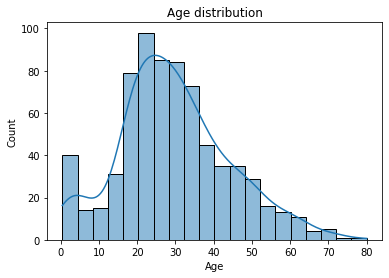

In [ ]:
fig, ax = plt.subplots()

sns.histplot(df.Age,kde=True, ax=ax);
ax.set(title="Age distribution");

In [ ]:
df.Age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


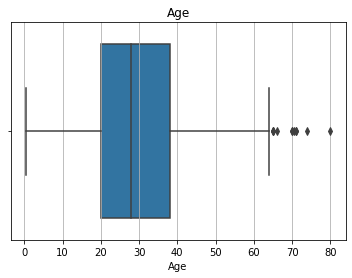

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(df_manipulate4["Age"], ax=ax);
ax.xaxis.grid(True);
ax.set(title="Age");

#### What affects age?

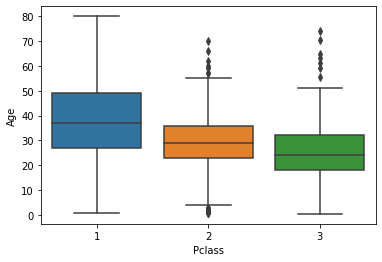

In [ ]:
sns.boxplot(x=df_manipulate4["Pclass"],y=df_manipulate4["Age"]);

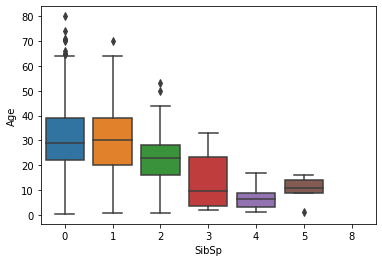

In [ ]:
sns.boxplot(x=df_manipulate4["SibSp"],y=df_manipulate4["Age"]);

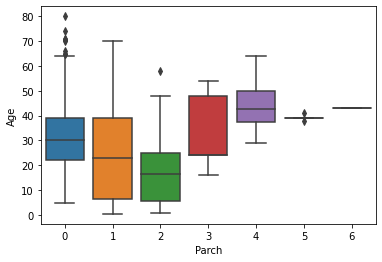

In [ ]:
sns.boxplot(x=df_manipulate4["Parch"],y=df_manipulate4["Age"]);

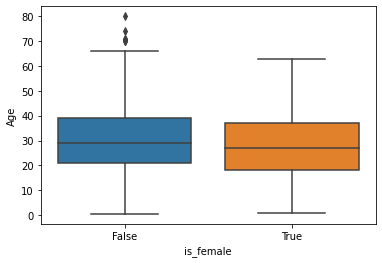

In [ ]:
sns.boxplot(x=df_manipulate4["is_female"],y=df_manipulate4["Age"]);

In [ ]:
df_manipulate4.groupby(["Parch"])["Age"].median()

Parch
0    30.0
1    23.0
2    16.5
3    24.0
4    42.5
5    39.0
6    43.0
Name: Age, dtype: float64

In [ ]:
df_manipulate4.groupby(["SibSp"])["Age"].median()

SibSp
0    29.0
1    30.0
2    23.0
3     9.5
4     6.5
5    11.0
8     NaN
Name: Age, dtype: float64

In [ ]:
pd.crosstab(df.Age[df.Age<=20],df.Parch)

Parch,0,1,2,3
Age,,,,
0.42,0,1,0,0
0.67,0,1,0,0
0.75,0,2,0,0
0.83,0,1,1,0
0.92,0,0,1,0
1.00,0,3,4,0
2.00,0,7,3,0
3.00,0,4,2,0
4.00,0,6,4,0


In [ ]:
df[df["Age"]<=10][df["Parch"]==0][df["SibSp"]==0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
777,778,1,3,"Emanuel, Miss. Virginia Ethel",female,5.0,0,0,364516,12.475,NaN,S


**<font color=red>5 year old and no Parents?? No way!**

Miss Virginia Ethel Emanuel, 5, boarded the Titanic at Southampton with her Nurse Miss Elizabeth Fierer who was escorting her to her grandparents home in New York, NY.
https://www.geni.com/people/Virginia-Ethel-Emanuel/6000000039819990813

In [ ]:
df_manipulate4.head(0)

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female


#### Age imputing ( Method 1)

In [ ]:
df_manipulate4.to_csv("drive/MyDrive/Github/Kaggle/Titanic/train_manipulate_to_4",index=False)

In [ ]:
df2 = pd.read_csv("drive/MyDrive/Github/Kaggle/Titanic/train_manipulate_to_4")
df2.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True
3,1,1,35.0,1,0,113803,53.1000,S,True
4,0,3,35.0,0,0,373450,8.0500,S,False


In [ ]:
df2_manipulate1 = df2.copy()
df2_manipulate1["Age_is_missing"] = df2.Age.isna()

###### Mehod 1. median of Parch

In [ ]:
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 0),
                    'Age'] = 30
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 1),
                    'Age'] = 23
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 2),
                    'Age'] = 17                    
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 3),
                    'Age'] = 24
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 4),
                    'Age'] = 43
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 5),
                    'Age'] = 39        
df2_manipulate1.loc[(np.isnan(df2_manipulate1['Age']) == True) & (df2_manipulate1["Parch"] == 6),
                    'Age'] = 43                                                                    

In [ ]:
df2_manipulate1["Age"].isna().sum()

0

In [ ]:
df2_manipulate1.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True,False
3,1,1,35.0,1,0,113803,53.1000,S,True,False
4,0,3,35.0,0,0,373450,8.0500,S,False,False


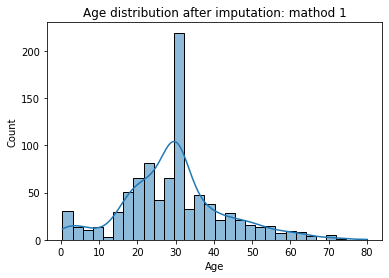

In [ ]:
fig, ax = plt.subplots()

sns.histplot(df2_manipulate1.Age,kde=True, ax=ax);
ax.set(title="Age distribution after imputation: mathod 1");

In [ ]:
iqr_boundary(df2_manipulate1["Age"])

Q1: 22.0, Q2: 30.0, Q3: 35.0 ,noramal boundary: from 2.5 to 54.5


In [ ]:
# Binning by quantile and label `outlier`
df2_manipulate2 = df2_manipulate1.copy()
df2_manipulate2.loc[(2.5 <= df2_manipulate1['Age'])&(df2_manipulate1['Age']<=22.0),
                    'Age_class'] = "Q1"
df2_manipulate2.loc[(22.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=30.0),
                    'Age_class'] = "Q2"
df2_manipulate2.loc[(30.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=35.0),
                    'Age_class'] = "Q3"                   
df2_manipulate2.loc[(35.0 < df2_manipulate1['Age'])&(df2_manipulate1['Age']<=54.5),
                    'Age_class'] = "Q4"

df2_manipulate2["Age_is_outlier"] = df2_manipulate2["Age_class"].isna()

df2_manipulate2.loc[df2_manipulate1['Age']<2.5,
                    'Age_class'] = "Q1"
df2_manipulate2.loc[54.5 < df2_manipulate1['Age'],
                    'Age_class'] = "Q1"                    

In [ ]:
df2_manipulate2[df2_manipulate2["Age_is_outlier"]==True].head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
7,0,3,2.0,3,1,349909,21.075,S,False,False,Q1,True
11,1,1,58.0,0,0,113783,26.550,S,True,False,Q1,True
15,1,2,55.0,0,0,248706,16.000,S,True,False,Q1,True
16,0,3,2.0,4,1,382652,29.125,Q,False,False,Q1,True
33,0,2,66.0,0,0,C.A. 24579,10.500,S,False,False,Q1,True


### SibSp and Parch
- In 891 people, most of their "SibSp" and "Parch" is 0, 1 or 2.
- Also, major amount of people **alone**.
  - another chanece: with friends or cowarkers
- 2nd major group is **SibSp = 1 and Parch = 0** means with spouse or with sibling.

In [ ]:
df2_manipulate2.head()

,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
0,0,3,22.0,1,0,A/5 21171,7.2500,S,False,False,Q1,False
1,1,1,38.0,1,0,PC 17599,71.2833,C,True,False,Q4,False
2,1,3,26.0,0,0,STON/O2. 3101282,7.9250,S,True,False,Q2,False
3,1,1,35.0,1,0,113803,53.1000,S,True,False,Q3,False
4,0,3,35.0,0,0,373450,8.0500,S,False,False,Q3,False


In [ ]:
pd.crosstab(df2_manipulate2.Survived,df2_manipulate2.SibSp)

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


In [ ]:
pd.crosstab(df2_manipulate2.Survived,df2_manipulate2.Parch)

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


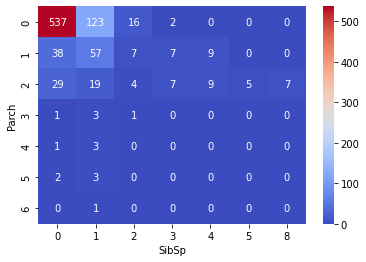

In [ ]:
ax = sns.heatmap(pd.crosstab(df2_manipulate2.Parch,df2_manipulate2.SibSp),annot=True, fmt="d",cmap="coolwarm");

### Ticket
ticket number and survival??
- I tried to handle with this data, but this should be ignored.

In [ ]:
df2_manipulate3 = df2_manipulate2.copy()
df2_manipulate3 = df2_manipulate3.drop("Ticket",axis=1)

In [ ]:
df2_manipulate3.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier
0,0,3,22.0,1,0,7.2500,S,False,False,Q1,False
1,1,1,38.0,1,0,71.2833,C,True,False,Q4,False
2,1,3,26.0,0,0,7.9250,S,True,False,Q2,False
3,1,1,35.0,1,0,53.1000,S,True,False,Q3,False
4,0,3,35.0,0,0,8.0500,S,False,False,Q3,False


### Fare
I assume that fare and survival have a positive correlation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


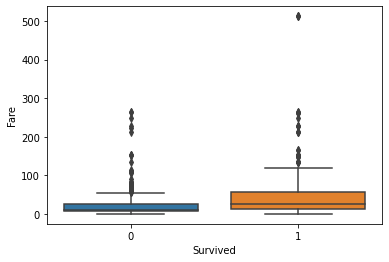

In [ ]:
sns.boxplot(df2_manipulate3.Survived,df2_manipulate3.Fare);

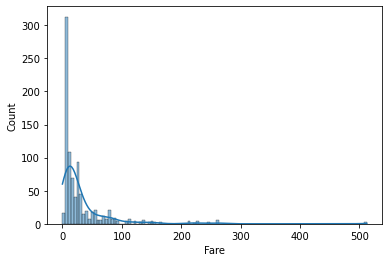

In [ ]:
sns.histplot(df2_manipulate3.Fare,kde=True);

In [ ]:
iqr_boundary(df2_manipulate3.Fare)

Q1: 7.9104, Q2: 14.4542, Q3: 31.0 ,normal boundary: from -26.724 to 65.6344


In [ ]:
iqr_boundary(df2_manipulate3.Fare[df2_manipulate3.Survived==1])

Q1: 12.475, Q2: 26.0, Q3: 57.0 ,normal boundary: from -54.31249999999999 to 123.7875


In [ ]:
iqr_boundary(df2_manipulate3.Fare[df2_manipulate3.Survived==0])

Q1: 7.8542, Q2: 10.5, Q3: 26.0 ,normal boundary: from -19.364500000000003 to 53.2187


In [ ]:
# Fare binning
df2_manipulate4 = df2_manipulate3.copy()
df2_manipulate4.loc[df2_manipulate3['Fare']<=7.9,
                    'Fare_class'] = "Q1"
df2_manipulate4.loc[(7.9 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=14.5),
                    'Fare_class'] = "Q2"
df2_manipulate4.loc[(14.5 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=31.0),
                    'Fare_class'] = "Q3"                   
df2_manipulate4.loc[(31.0 < df2_manipulate3['Fare'])&(df2_manipulate3['Fare']<=65.7),
                    'Fare_class'] = "Q4"

df2_manipulate4["Fare_is_outlier"] = df2_manipulate4["Fare_class"].isna()

df2_manipulate4.loc[65.7 < df2_manipulate3['Fare'],
                    'Fare_class'] = "Q4"     

In [ ]:
df2_manipulate4.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier
0,0,3,22.0,1,0,7.2500,S,False,False,Q1,False,Q1,False
1,1,1,38.0,1,0,71.2833,C,True,False,Q4,False,Q4,True
2,1,3,26.0,0,0,7.9250,S,True,False,Q2,False,Q2,False
3,1,1,35.0,1,0,53.1000,S,True,False,Q3,False,Q4,False
4,0,3,35.0,0,0,8.0500,S,False,False,Q3,False,Q2,False


### Embarked
- only 2 missing value
- Signigicant impact if "S" or not

In [ ]:
df2_manipulate5 = df2_manipulate4.copy()
df2_manipulate5["Embarked_is_missing"] = df2_manipulate5["Embarked"].isna()
df2_manipulate5["Embarked"].fillna("missing",inplace=True)

In [ ]:
df2_manipulate5[df2_manipulate5["Embarked"]=="missing"]

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier,Embarked_is_missing
61,1,1,38.0,0,0,80.0,missing,True,False,Q4,False,Q4,True,True
829,1,1,62.0,0,0,80.0,missing,True,False,Q1,True,Q4,True,True


In [ ]:
pd.crosstab(df2_manipulate5.Embarked,df2_manipulate5.Survived)

Survived,0,1
Embarked,,
C,75,93
Q,47,30
S,427,217
missing,0,2


In [ ]:
 # Embarked difference among C, Q and S
 chi2, p, df, exected = chi2_contingency(pd.crosstab(df2_manipulate5.Embarked[df2_manipulate5.Embarked != "missing"],df2_manipulate5.Survived))
 print(f"p-value: {p}")

p-value: 1.769922284120912e-06


In [ ]:
 # Embarked difference between C and Q
 chi2, p, df, exected = chi2_contingency(pd.crosstab(df2_manipulate5.Embarked[(df2_manipulate5.Embarked != "missing")&(df2_manipulate5.Embarked != "S")],df2_manipulate5.Survived))
 print(f"p-value: {p}")

p-value: 0.02475540003497518


In [ ]:
df2_manipulate6 = df2_manipulate5.copy()
df2_manipulate6["Embarked_is_S"] = df2_manipulate5["Embarked"] == "S"
df2_manipulate6 = df2_manipulate6.drop("Embarked",axis=1)

In [ ]:
df2_manipulate6.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier,Embarked_is_missing,Embarked_is_S
0,0,3,22.0,1,0,7.2500,False,False,Q1,False,Q1,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,Q4,False,Q4,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,Q2,False,Q2,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,Q3,False,Q4,False,False,True
4,0,3,35.0,0,0,8.0500,False,False,Q3,False,Q2,False,False,True


# Data preprocessing
- 1. drop Cabin
- 2. drop PassengerId
- 3. drop Name
- 4. Turn Sex into "is_female" and drop Sex
- 5. <font color=red>Age imputation</font>
  - 5-1. midium of each Parch
   - 5-1-1. age binning (Age_class)
  - 5-2. midium of each SibSp
  - 5-3. (average, max, min) of 5-1 and 5-2
  - 5-4. sqet of 5-1 and 5-2
- 6. drop Ticket 
- 7. Fare binning
- 8. Embark --> "S", "not S", and "missing"

## Preprocessing

In [27]:
def preprocessing(data):
  #1,2,3
  # data.drop(["Cabin","PassengerId","Name"],axis=1,inplace=True)
  data.drop(["Cabin","Name"],axis=1,inplace=True)
  #4
  data["is_female"] = data["Sex"] == "female"
  data.drop("Sex",axis=1,inplace=True)
  #5-1
  data["Age_is_missing"] = data.Age.isna()

  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 0),
                    'Age'] = 30
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 1),
                      'Age'] = 23
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 2),
                      'Age'] = 17                    
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 3),
                      'Age'] = 24
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 4),
                      'Age'] = 43
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 5),
                      'Age'] = 39        
  data.loc[(np.isnan(data['Age']) == True) & (data["Parch"] == 6),
                      'Age'] = 43  
  data.loc[(2.5 <= data['Age'])&(data['Age']<=22.0),
                      'Age_class'] = "Q1"
  data.loc[(22.0 < data['Age'])&(data['Age']<=30.0),
                      'Age_class'] = "Q2"
  data.loc[(30.0 < data['Age'])&(data['Age']<=35.0),
                      'Age_class'] = "Q3"                   
  data.loc[(35.0 < data['Age'])&(data['Age']<=54.5),
                      'Age_class'] = "Q4"

  data["Age_is_outlier"] = data["Age_class"].isna()
  data.loc[data['Age']<2.5,
                      'Age_class'] = "Q1"
  data.loc[54.5 < data['Age'],
                      'Age_class'] = "Q1"      

  #6
  data.drop("Ticket",axis=1,inplace=True)

  #7
  # Fare binning
  data.loc[data['Fare']<=7.9,
                      'Fare_class'] = "Q1"
  data.loc[(7.9 < data['Fare'])&(data['Fare']<=14.5),
                      'Fare_class'] = "Q2"
  data.loc[(14.5 < data['Fare'])&(data['Fare']<=31.0),
                      'Fare_class'] = "Q3"                   
  data.loc[(31.0 < data['Fare'])&(data['Fare']<=65.7),
                      'Fare_class'] = "Q4"

  data["Fare_is_outlier"] = data["Fare_class"].isna()

  data.loc[65.7 < data['Fare'],
                      'Fare_class'] = "Q4"    
  #8
  data["Embarked_is_missing"] = data["Embarked"].isna()
  data["Embarked"].fillna("missing", inplace=True)
  data["Embarked_is_S"] = data["Embarked"] == "S"
  data.drop("Embarked",axis=1,inplace=True)

In [3]:
data_tmp = pd.read_csv("drive/MyDrive/Github/Kaggle/Titanic/data/train.csv")
preprocessing(data_tmp)
data_tmp.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier,Embarked_is_missing,Embarked_is_S
0,0,3,22.0,1,0,7.2500,False,False,Q1,False,Q1,False,False,True
1,1,1,38.0,1,0,71.2833,True,False,Q4,False,Q4,True,False,False
2,1,3,26.0,0,0,7.9250,True,False,Q2,False,Q2,False,False,True
3,1,1,35.0,1,0,53.1000,True,False,Q3,False,Q4,False,False,True
4,0,3,35.0,0,0,8.0500,False,False,Q3,False,Q2,False,False,True


## OneHot encoding

In [24]:
#One Hot Encoding
X = data_tmp.drop("Survived",axis=1)
y = data_tmp.Survived
categorical_features = ["is_female","Age_is_missing","Age_class","Age_is_outlier","Fare_class","Fare_is_outlier","Embarked_is_missing","Embarked_is_S"]
one_hot = OneHotEncoder()

transformer = ColumnTransformer([("one_hot",one_hot,categorical_features)],
                                remainder="passthrough")
transformed_X  = transformer.fit_transform(X)

In [25]:
transformed_X.shape, y.shape

((891, 25), (891,))

In [26]:
len(transformer.get_feature_names_out())

25

# Model
- discard naive Bayes

In [8]:
# model dictionary
models = {"Random Forest":RandomForestClassifier(),
          "Logistic Regression":LogisticRegression(),
          "KNN":KNeighborsClassifier(),
          "Naive-Bayes":GaussianNB()}

def evaluate_model(models):
  """
  build, fit and evaluate for each model in `models`

  models: dict
  """
  scores={}
  for model_name,model in models.items():
    model.fit(X_train,y_train)
    scores[model_name] = model.score(X_valid,y_valid)
  return scores

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(transformed_X, y, test_size=0.2)

In [11]:
from warnings import filterwarnings
filterwarnings("ignore")
for _ in range(10):
  X_train, X_valid, y_train, y_valid = train_test_split(transformed_X, y, test_size=0.2)
  print(evaluate_model(models))
  print("+"*100)
print("finished!")

{'Random Forest': 0.7988826815642458, 'Logistic Regression': 0.8547486033519553, 'KNN': 0.7374301675977654, 'Naive-Bayes': 0.6983240223463687}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.8044692737430168, 'Logistic Regression': 0.7988826815642458, 'KNN': 0.6815642458100558, 'Naive-Bayes': 0.6536312849162011}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.7541899441340782, 'Logistic Regression': 0.7541899441340782, 'KNN': 0.659217877094972, 'Naive-Bayes': 0.6256983240223464}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.8212290502793296, 'Logistic Regression': 0.8100558659217877, 'KNN': 0.6871508379888268, 'Naive-Bayes': 0.7206703910614525}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.79329

## Feature_importance

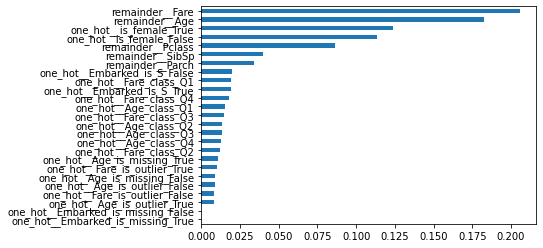

In [29]:
# Random Forest
X_train, X_valid, y_train, y_valid = train_test_split(transformed_X, y, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

feat_importances = pd.Series(clf.feature_importances_, index=transformer.get_feature_names_out())
feat_importances.nsmallest(25).plot(kind='barh');

drop
- "Embarked_is_missing"
- "Age_is_missing"
- "Age_is_outlier"
- "Fare_is_outlier"

In [4]:
#One Hot Encoding
X = data_tmp[["Fare","Age","is_female","Pclass"]]
y = data_tmp.Survived
categorical_features = ["is_female"]
one_hot = OneHotEncoder()

transformer = ColumnTransformer([("one_hot",one_hot,categorical_features)],
                                remainder="passthrough")
transformed_X  = transformer.fit_transform(X)

In [47]:
transformed_X.shape

(891, 5)

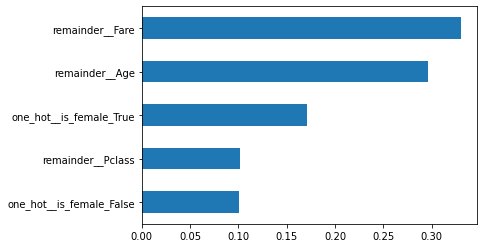

In [48]:
# Random Forest Retrial
X_train, X_valid, y_train, y_valid = train_test_split(transformed_X, y, test_size=0.2)
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

feat_importances = pd.Series(clf.feature_importances_, index=transformer.get_feature_names_out())
feat_importances.nsmallest(17).plot(kind='barh');

In [51]:
from warnings import filterwarnings
filterwarnings("ignore")
for _ in range(10):
  X_train, X_valid, y_train, y_valid = train_test_split(transformed_X, y, test_size=0.2)
  print(evaluate_model(models))
  print("+"*100)
print("finished!")

{'Random Forest': 0.8100558659217877, 'Logistic Regression': 0.7932960893854749, 'KNN': 0.7318435754189944, 'Naive-Bayes': 0.8044692737430168}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.8324022346368715, 'Logistic Regression': 0.8156424581005587, 'KNN': 0.7262569832402235, 'Naive-Bayes': 0.8100558659217877}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.8659217877094972, 'Logistic Regression': 0.776536312849162, 'KNN': 0.6983240223463687, 'Naive-Bayes': 0.7597765363128491}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.8268156424581006, 'Logistic Regression': 0.776536312849162, 'KNN': 0.6927374301675978, 'Naive-Bayes': 0.770949720670391}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
{'Random Forest': 0.7988826

## Evaluation

In [52]:
score_metrics = ["accuracy","precision","recall","f1","roc_auc"]
print("+"*40,"cv executed...","+"*40)
for model_name, model in models.items():
  print(f"model_name: {model_name}")
  for metric in score_metrics:
    cv_score = cross_validate( estimator=model,
                                    X=transformed_X,
                                    y=y,
                                    cv=5,
                                    verbose=False,
                                    n_jobs=-1,
                                    scoring=metric
                                    )
    score = cv_score["test_score"]
    print(f"{metric}\n{score}")
  print("+"*40,f"{model_name}: success!!","+"*40)

++++++++++++++++++++++++++++++++++++++++ cv executed... ++++++++++++++++++++++++++++++++++++++++
model_name: Random Forest
accuracy
[0.75977654 0.8258427  0.87078652 0.79213483 0.84269663]
precision
[0.73134328 0.73529412 0.85483871 0.77777778 0.77777778]
recall
[0.69565217 0.70588235 0.77941176 0.66176471 0.8115942 ]
f1
[0.69117647 0.73684211 0.80916031 0.70967742 0.78571429]
roc_auc
[0.81640316 0.81804813 0.89204545 0.86062834 0.88458982]
++++++++++++++++++++++++++++++++++++++++ Random Forest: success!! ++++++++++++++++++++++++++++++++++++++++
model_name: Logistic Regression
accuracy
[0.7877095  0.78651685 0.78651685 0.7752809  0.79213483]
precision
[0.71830986 0.70833333 0.72058824 0.75925926 0.75806452]
recall
[0.73913043 0.75       0.72058824 0.60294118 0.68115942]
f1
[0.72857143 0.72857143 0.72058824 0.67213115 0.71755725]
roc_auc
[0.82700922 0.83048128 0.8467246  0.84084225 0.85999202]
++++++++++++++++++++++++++++++++++++++++ Logistic Regression: success!! ++++++++++++++++++++++

## Random Forest Tuning

In [5]:
X_tune, X_tune_valid, y_tune, y_tune_valid = train_test_split(transformed_X,y, test_size=0.2, random_state=42)

In [8]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [15]:
%load_ext autotime
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(estimator = clf, 
                                param_distributions = random_grid, 
                                n_iter = 100, 
                                cv = 5, 
                                verbose=False, 
                                random_state=42, 
                                n_jobs = -1)
# Fit the random search model
print("start...")
clf_random.fit(X_tune, y_tune)

start...


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=False)

time: 12min 36s (started: 2022-03-16 12:43:21 +00:00)


In [16]:
clf_random.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1600}

time: 14.2 ms (started: 2022-03-16 12:58:34 +00:00)


## Re-Evaluation

In [18]:
y_pred = clf_random.predict(X_tune_valid)

time: 570 ms (started: 2022-03-16 13:00:39 +00:00)


In [21]:
print(classification_report(y_tune_valid,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

time: 24.1 ms (started: 2022-03-16 13:04:54 +00:00)


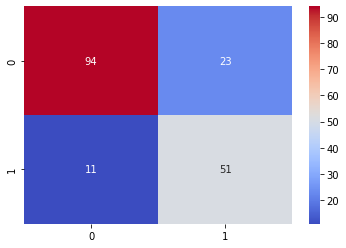

time: 399 ms (started: 2022-03-16 13:13:02 +00:00)


In [26]:
conf_mat = confusion_matrix(y_pred,y_tune_valid)
sns.heatmap(conf_mat,annot=True,cmap="coolwarm");

## Grid Search

In [32]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 10, stop = 30, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

time: 12.8 ms (started: 2022-03-16 13:23:36 +00:00)


In [33]:
clf = RandomForestClassifier()
clf_grid = GridSearchCV(estimator = clf,
                        param_grid = param_grid,
                        n_jobs=-1,
                        verbose=False,
                        cv=5)
print("start...")
clf_grid.fit(X_tune,y_tune)

start...


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 30, None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [10],
                         'n_estimators': [1200, 1208, 1216, 1224, 1232, 1240,
                                          1248, 1256, 1264, 1272, 1280, 1288,
                                          1296, 1305, 1313, 1321, 1329, 1337,
                                          1345, 1353, 1361, 1369, 1377, 1385,
                                          1393, 1402, 1410, 1418, 1426, 1434, ...]},
             verbose=False)

time: 56min 49s (started: 2022-03-16 13:23:39 +00:00)


In [52]:
clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1305}

time: 4.5 ms (started: 2022-03-16 14:35:30 +00:00)


In [55]:
dump(clf_grid, 'drive/MyDrive/Github/Kaggle/Titanic/random_forest_gridCV_20220316_saved.joblib')

['drive/MyDrive/Github/Kaggle/Titanic/random_forest_gridCV_20220316_saved.joblib']

time: 1.29 s (started: 2022-03-16 14:38:31 +00:00)


## Final Evaluation

In [35]:
y_pred_grid = clf_grid.predict(X_tune_valid)

time: 606 ms (started: 2022-03-16 14:23:00 +00:00)


In [36]:
print(classification_report(y_tune_valid,y_pred_grid))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       105
           1       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

time: 23.3 ms (started: 2022-03-16 14:23:34 +00:00)


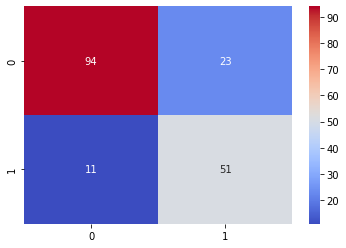

time: 426 ms (started: 2022-03-16 14:24:53 +00:00)


In [39]:
conf_mat2 = confusion_matrix(y_pred_grid,y_tune_valid)
sns.heatmap(conf_mat2,annot=True,cmap="coolwarm");

# Test
## difference from training data
1. Age = NaN and Parch = 9
2. Fare contains NaN

For Age, I imputed 43, as of Parch 6.
For Fare, I imputed 14.5, which is median.

In [38]:
test_data = pd.read_csv("/content/drive/MyDrive/Github/Kaggle/Titanic/data/test.csv")

In [39]:
preprocessing(test_data)

In [6]:
test_data[test_data["Age"].isna()==True]

,Pclass,Age,SibSp,Parch,Fare,is_female,Age_is_missing,Age_class,Age_is_outlier,Fare_class,Fare_is_outlier,Embarked_is_missing,Embarked_is_S
342,3,NaN,1,9,69.55,False,True,NaN,True,Q4,True,False,True
365,3,NaN,1,9,69.55,True,True,NaN,True,Q4,True,False,True


In [40]:
test_data.loc[(np.isnan(test_data['Age']) == True) & (test_data["Parch"] == 9),
                      'Age'] = 43  

In [41]:
test_data.loc[np.isnan(test_data['Fare']) == True,
                      'Fare'] = 14.5  

In [42]:
test_data.isna().sum()

PassengerId            0
Pclass                 0
Age                    0
SibSp                  0
Parch                  0
Fare                   0
is_female              0
Age_is_missing         0
Age_class              2
Age_is_outlier         0
Fare_class             1
Fare_is_outlier        0
Embarked_is_missing    0
Embarked_is_S          0
dtype: int64

In [43]:
#One Hot Encoding
X = test_data[["Fare","Age","is_female","Pclass"]]
categorical_features = ["is_female"]
one_hot = OneHotEncoder()

transformer = ColumnTransformer([("one_hot",one_hot,categorical_features)],
                                remainder="passthrough")
transformed_X  = transformer.fit_transform(X)

In [44]:
transformed_X.shape

(418, 5)

In [45]:
loaded_model = load("/content/drive/MyDrive/Github/Kaggle/Titanic/random_forest_gridCV_20220316_saved.joblib")

In [46]:
y_pred_test = loaded_model.predict(transformed_X)

In [47]:
y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [48]:
df = pd.DataFrame()
df["PassengerId"] = test_data["PassengerId"]
df["Survived"] = y_pred_test

In [52]:
df.to_csv("drive/MyDrive/Github/Kaggle/Titanic/submission20220316.csv",index=False)

# Submission completed -- Score: 0.76555
## another idea
1. Imputing method (age imputation)
2. Hypertuning with Logistic Regression model
3. Boosting (?) I need more study!

## If I do it again...
Data exploration must be more shorter, and perform model-driven feature analysis first.